<a href="https://colab.research.google.com/github/potis/AISummit/blob/main/AI_Summit_2023_Part_1_MNIST_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scope

Designing an image classification system that generates uncertainty estimates and performs out-of- distribution detection

## Install necessary libraries


In [2]:
!pip install pip --upgrade
!pip install medmnist
!pip install autokeras
!pip install numpy
!pip install scikeras
!pip install -U -q --use-deprecated=legacy-resolver tf-models-official tensorflow
!pip install tensorflow_probability
!pip install --upgrade tf_agents


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=f9e9cf1c97e3b8aaf2bb4308ac5a4f24bc288a82e713dc4b39a5c9d20474af27
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 

## Load the dataset

In [61]:
# Load the data
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import time
import medmnist
import random
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import *
from sklearn import metrics as sklearn_metrics
import seaborn as sns
from tensorflow.keras.utils import to_categorical



def plot_confusion_matrix(y_true, y_pred):
    result = y_pred
    cf_matrix = sklearn_metrics.confusion_matrix(y_true, result)

    cfm_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    cfm_values = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    cfm_percent = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cfm_labels, cfm_values, cfm_percent)]
    labels = np.asarray(labels).reshape(2, 2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title('Classifier\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values')

    # Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False', 'True'])
    ax.yaxis.set_ticklabels(['False', 'True'])

    # Display the visualization of the Confusion Matrix.
    plt.show()




def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

(train_data, train_labels), (test_data, test_labels) =keras.datasets.mnist.load_data()
print(np.shape(train_data))
print(np.shape(train_labels))

train_filter = np.where((train_labels == 0 ) | (train_labels == 4))
test_filter = np.where((test_labels == 0) | (test_labels == 4))
ood_filter= np.where((test_labels == 9) )


X_train, Y_train = train_data[train_filter], train_labels[train_filter]
Y_train[Y_train==4]=1
Y_train_c=to_categorical(Y_train)
X_test, Y_test = test_data[test_filter], test_labels[test_filter]
Y_test[Y_test==4]=1

ood_test= test_data[ood_filter]

print(np.shape(Y_train))
print(np.shape(X_train))
print(Y_train.max())

(60000, 28, 28)
(60000,)
(11765,)
(11765, 28, 28)
1


## Show some samples image

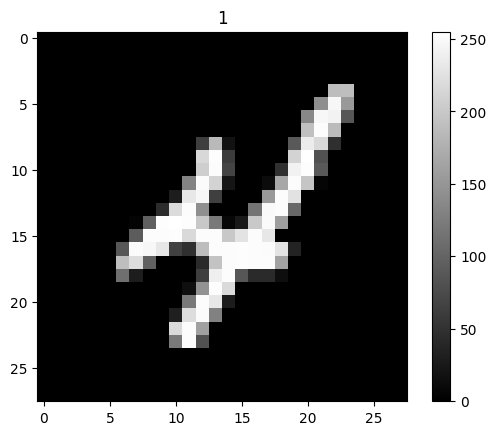

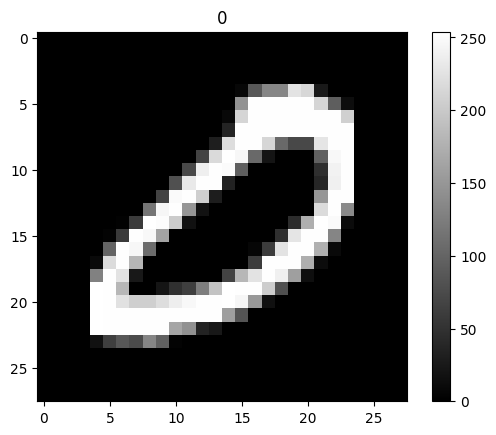

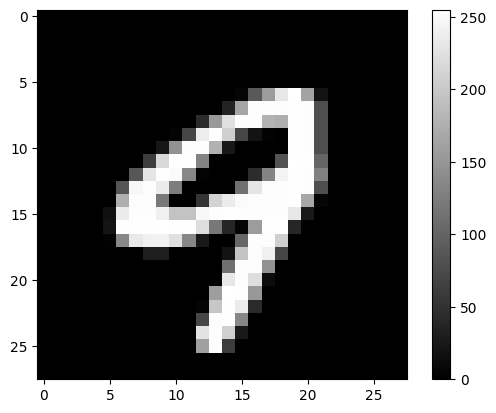

In [4]:
plt.figure()
plt.title(str(Y_train[2]))
plt.imshow(X_train[2, :,:], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
plt.figure()
plt.title(str(Y_train[-1]))

plt.imshow(X_train[-1, :,:], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
plt.figure()
plt.imshow(ood_test[-1, :,:], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()


## Create model

In [5]:
batch_size = 32
img_height = 28
img_width = 28


from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier

class MyModel(models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = self.build_model()

    def build_model(self):
        model = models.Sequential()
        model.add(layers.Rescaling(1./255, input_shape=(28, 28, 1)))
        model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='relu'))
        model.add(layers.Dropout(.25))
        model.add(layers.Dense(2, activation='sigmoid'))
        return model

    def call(self, inputs):
        return self.model(inputs)

model = MyModel()
model.build(((None,None,None, 1)))

model.summary()




model.compile(optimizer=tf.keras.optimizers.Adam(
              learning_rate=0.0001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
epochs=5

model.fit(
    X_train,
    Y_train_c,
    validation_split=0.3,
    epochs=epochs,
)



Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2)                 111154    
                                                                 
Total params: 111,154
Trainable params: 111,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
258/258 [==============================] - 18s 13ms/step - loss: 0.2376 - accuracy: 0.9564 - val_loss: 0.0185 - val_accuracy: 0.9960
Epoch 2/5
258/258 [==============================] - 2s 10ms/step - loss: 0.0274 - accuracy: 0.9938 - val_loss: 0.0150 - val_accuracy: 0.9946
Epoch 3/5
258/258 [==============================] - 5s 18ms/step - loss: 0.0184 - accuracy: 0.9964 - val_loss: 0.0083 - val_accuracy: 0.9980
Epoch 4/5
258/258 [==============================] - 4s 15ms/step - loss: 0.0166 - accuracy: 0.9953 - val_loss: 0.0074 - val_accuracy: 0.9983
Epoch 5/5
2

## Evaluate the model

(1962, 2)
(1962, 2)


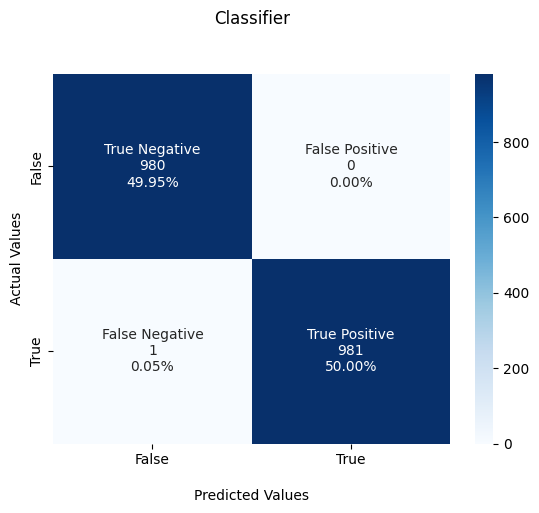

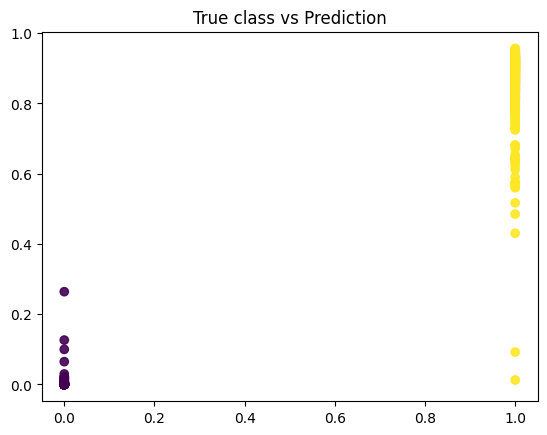

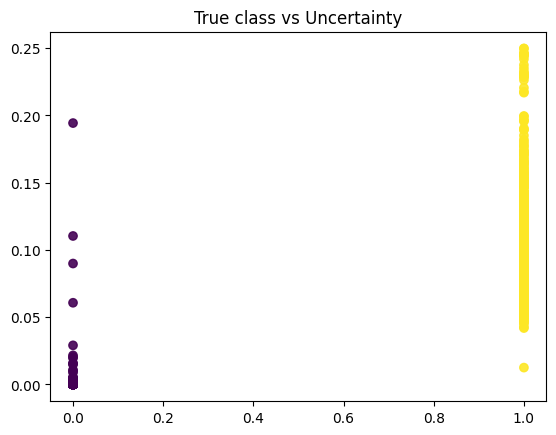

In [12]:
predictions=model(X_test)
predictions=predictions.numpy()
print(np.shape(predictions))

predictions_bin=predictions.argmax(axis=-1)
print(np.shape(predictions))
plot_confusion_matrix(Y_test, predictions_bin)

plt.title('True class vs Prediction')
plt.scatter(Y_test, predictions[:,1], c= list(Y_test), alpha=0.9)
plt.show()

plt.title('True class vs Uncertainty')

uncertainty =  predictions[:,1] * (1 -  predictions[:,1])
plt.scatter(Y_test, uncertainty, c= list(Y_test), alpha=0.9)
plt.show()


### Test model in a sample originating from the test set

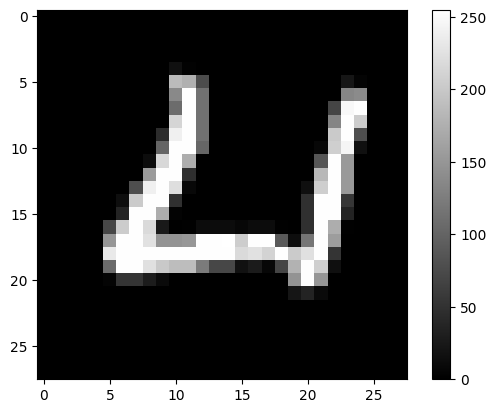

(1, 2)
Indistribution sample
0.78127295
0.17088552884251484
Rotating image 90 degrees
0.4986675
0.24999822446603925
Fliping image upside down
0.0020748598
0.0020705547603381384


In [17]:
# resnet_uncertainty = resnet_probs * (1 - resnet_probs)
# Get a sample
example_case=10
sample=X_test[example_case, :,:]
plt.figure()
plt.imshow(sample, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
sample=np.reshape(sample,(1,28,28))
predictions_sample=model(sample)
predictions_sample=predictions_sample.numpy()
print(np.shape(predictions_sample))
predictions_sample=predictions_sample[0,1]
print('Indistribution sample')
print(predictions_sample)
uncertainty = predictions_sample * (1 - predictions_sample)
print(uncertainty)
# What if we just rotate?
print('Rotating image 90 degrees')
rot_sample=np.rot90(X_test[example_case, :,:],1).reshape((1,28,28))
predictions_sample=model(rot_sample)
predictions_sample=predictions_sample.numpy()
predictions_sample=predictions_sample[0,1]

print(predictions_sample)
uncertainty = predictions_sample * (1 - predictions_sample)
print(uncertainty)
rot_sample=np.flipud(X_test[example_case, :,:]).reshape((1,28,28))
predictions_sample=model(rot_sample)
predictions_sample=predictions_sample.numpy()
predictions_sample=predictions_sample[0,1]

print('Fliping image upside down')
print(predictions_sample)
uncertainty = predictions_sample * (1 - predictions_sample)
print(uncertainty)

### Test model in out of distribution data (Deterministic Model)

In [19]:
# resnet_uncertainty = resnet_probs * (1 - resnet_probs)
# Get a sample
sample=ood_test[4, :,:]
sample=np.reshape(sample,(1,28,28))
predictions=model(sample)
predictions=predictions.numpy()
predictions=predictions[0,1]
print(predictions)
uncertainty = predictions * (1 - predictions)
print(uncertainty)

0.35744318
0.22967755411514812


#### Apply to all the OOD and plot uncertainty

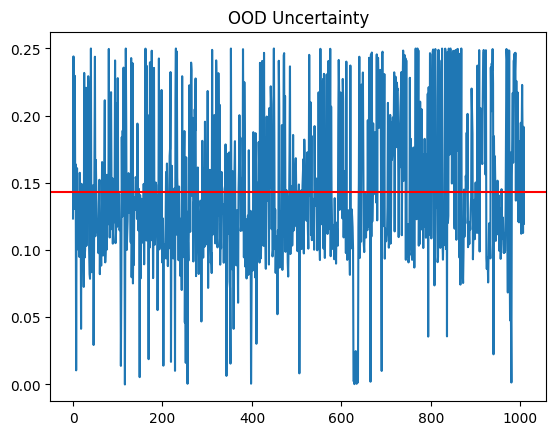

In [20]:
predictions=model(ood_test)
predictions=predictions.numpy()
predictions=predictions[:,1]

uncertainty = predictions * (1 - predictions)
plt.title('OOD Uncertainty')
uncertainty = predictions * (1 - predictions)
plt.plot(uncertainty)
plt.axhline(y=uncertainty.mean(),color = 'r', linestyle = '-')
plt.show()

#### Apply to all the test cases and plot uncertainty

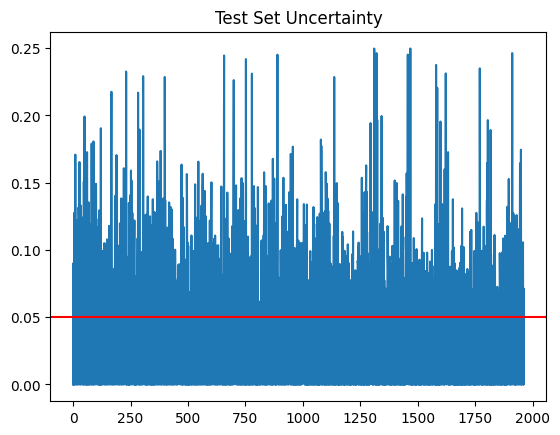

In [21]:
predictions=model(X_test)
predictions=predictions.numpy()
predictions=predictions[:,1]

uncertainty = predictions * (1 - predictions)
plt.title('Test Set Uncertainty')
uncertainty = predictions * (1 - predictions)
plt.plot(uncertainty)
plt.axhline(y=uncertainty.mean(),color = 'r', linestyle = '-')
plt.show()

## Monte Carlo dropout

In [23]:
num_ensemble = 100
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  return model(test_examples, training=True)

### In distribution

In [25]:
# Get a sample
sample=X_test[0,:,:]
print(f"True Class {Y_test[0]}")
sample=np.reshape(sample,(1,28,28))
dropout_samples = [mc_dropout_sampling(sample).numpy()[0,1] for _ in range(num_ensemble)]
print(np.array(dropout_samples).mean())
uncertainty = np.array(dropout_samples).mean() * (1 - np.array(dropout_samples).mean())
print(uncertainty)
# Get a sample
sample=X_test[10,:,:]
print(f"True Class {Y_test[10]}")
sample=np.reshape(sample,(1,28,28))
dropout_samples = [mc_dropout_sampling(sample).numpy()[0,1] for _ in range(num_ensemble)]
print(np.array(dropout_samples).mean())
uncertainty = np.array(dropout_samples).mean() * (1 - np.array(dropout_samples).mean())
print(uncertainty)


True Class 0
0.0012561412
0.0012545633387441271
True Class 1
0.72388184
0.19987692140215074


### Out of distribution example

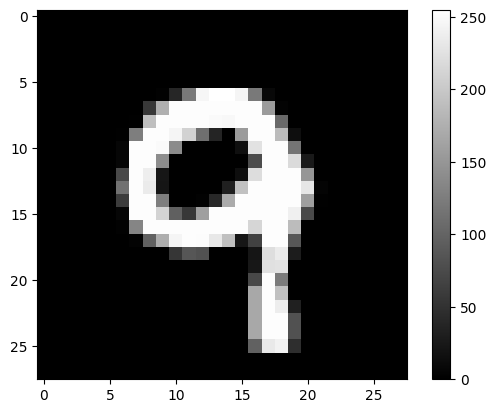

[0.09239744, 0.0096890535, 0.31289634, 0.31289634, 0.08003637, 0.5096081, 0.864106, 0.91649115, 0.85554165, 0.31908113, 0.11286025, 0.5167569, 0.1847305, 0.5096081, 0.0096890535, 0.78245836, 0.29908794, 0.28619882, 0.07248192, 0.31289634, 0.7550183, 0.8423038, 0.45986736, 0.046903566, 0.31289634, 0.08003637, 0.6763727, 0.78581953, 0.93740135, 0.28215942, 0.34509018, 0.66831845, 0.27668536, 0.37259254, 0.476057, 0.08336162, 0.23498355, 0.85797864, 0.581546, 0.08710792, 0.041929632, 0.41692966, 0.8677623, 0.30681717, 0.082924925, 0.7668392, 0.6501835, 0.2519953, 0.48227686, 0.29908794, 0.042496953, 0.19786376, 0.7359006, 0.10198246, 0.7069319, 0.040795054, 0.42310616, 0.0023654646, 0.48227686, 0.4777978, 0.65039575, 0.10463315, 0.23498355, 0.90314794, 0.91924715, 0.8278619, 0.71095973, 0.5766603, 0.31908113, 0.7139964, 0.31289634, 0.9763242, 0.8824252, 0.09239744, 0.6010462, 0.63114464, 0.10463315, 0.09239744, 0.18045966, 0.9323683, 0.31289634, 0.46892485, 0.31289634, 0.2643975, 0.092397

In [26]:
plt.figure()
plt.imshow(ood_test[10, :,:], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()
sample_ood=ood_test[4,:,:]
sample_ood=np.reshape(sample_ood,(1,28,28))
dropout_samples_ood = [mc_dropout_sampling(sample_ood).numpy()[0,1] for _ in range(num_ensemble)]
print(dropout_samples_ood)
print(np.array(dropout_samples_ood).mean())
uncertainty = np.array(dropout_samples_ood).mean() * (1 - np.array(dropout_samples_ood).mean())
print(uncertainty)


## Deep Ensemble

In [31]:
num_ensemble=3
# Deep ensemble training
deep_ensemble = []
import random


for ivar in range(num_ensemble):
  print(f'{ivar}')
  tf.keras.utils.set_random_seed(random.randint(100,1000))
  temp_model= MyModel()
  temp_model.build(((None,None,None, 1)))

  temp_model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
  temp_model.reset_states()
  temp_model.fit(
    X_train,
    Y_train_c,
    validation_split=0.3,
    epochs=epochs)
  print(f'------')

  deep_ensemble.append(temp_model)

  del temp_model

0
Epoch 1/5
258/258 [==============================] - 6s 7ms/step - loss: 0.0725 - accuracy: 0.9800 - val_loss: 0.0134 - val_accuracy: 0.9966
Epoch 2/5
258/258 [==============================] - 2s 6ms/step - loss: 0.0227 - accuracy: 0.9973 - val_loss: 0.0056 - val_accuracy: 0.9983
Epoch 3/5
258/258 [==============================] - 2s 6ms/step - loss: 0.0093 - accuracy: 0.9990 - val_loss: 0.0060 - val_accuracy: 0.9989
Epoch 4/5
258/258 [==============================] - 2s 6ms/step - loss: 0.0069 - accuracy: 0.9990 - val_loss: 0.0074 - val_accuracy: 0.9989
Epoch 5/5
258/258 [==============================] - 2s 6ms/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0151 - val_accuracy: 0.9960
------
1
Epoch 1/5
258/258 [==============================] - 6s 10ms/step - loss: 0.0491 - accuracy: 0.9823 - val_loss: 0.0120 - val_accuracy: 0.9975
Epoch 2/5
258/258 [==============================] - 2s 8ms/step - loss: 0.0098 - accuracy: 0.9979 - val_loss: 0.0073 - val_accuracy: 0.9989
E

0.9999988
1.192091474422341e-06


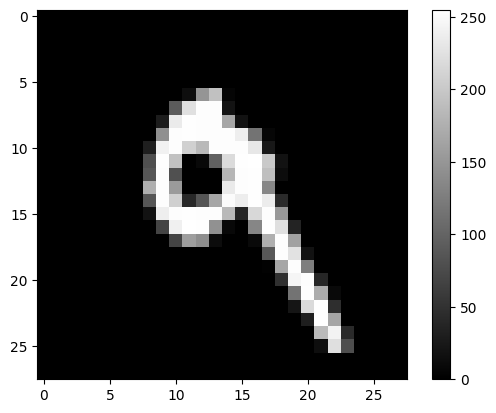

0.9999303
6.967297474247403e-05


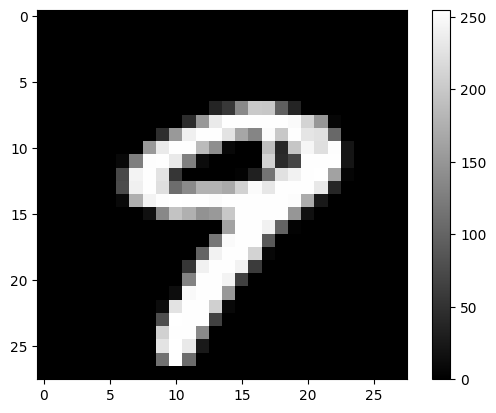

0.9688676
0.030163173703865453


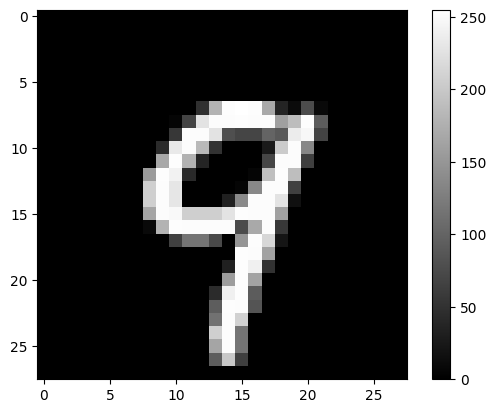

0.99963456
0.0003653025335914606


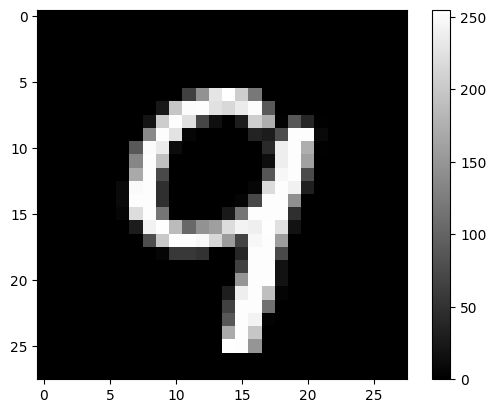

0.9975357
0.002458221686538309


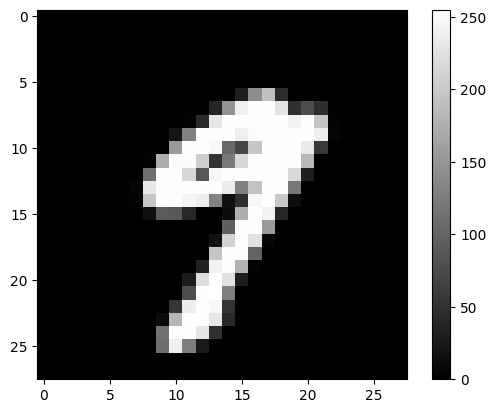

0.99535674
0.0046217015559157915


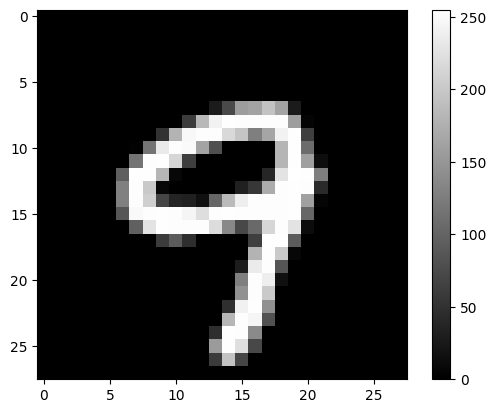

0.99767524
0.0023193554513021297


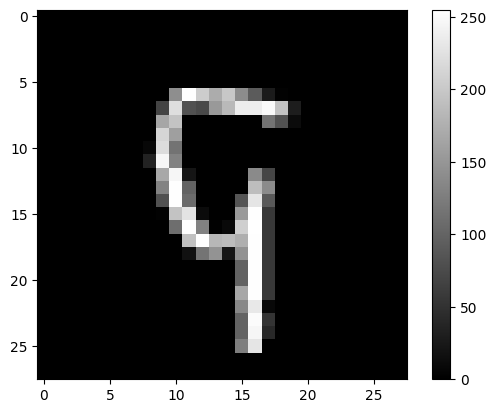

0.9954257
0.004553374648594399


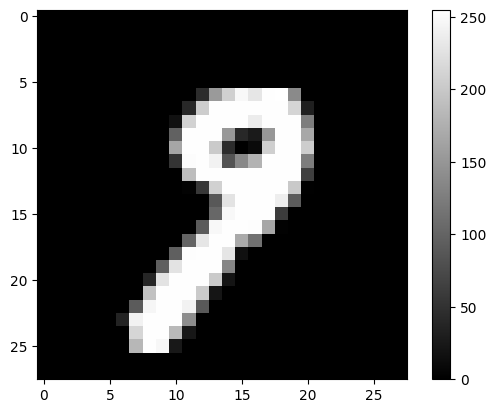

0.7842603
0.16919609720548578


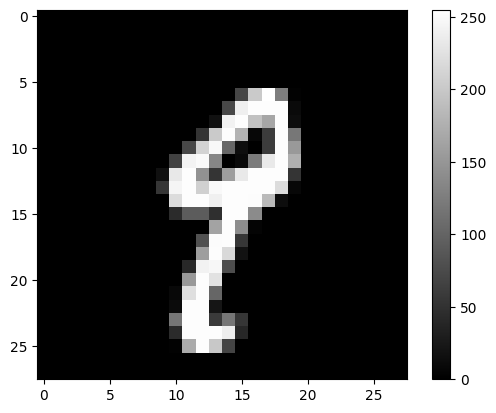

0.9942482
0.005718705543895197


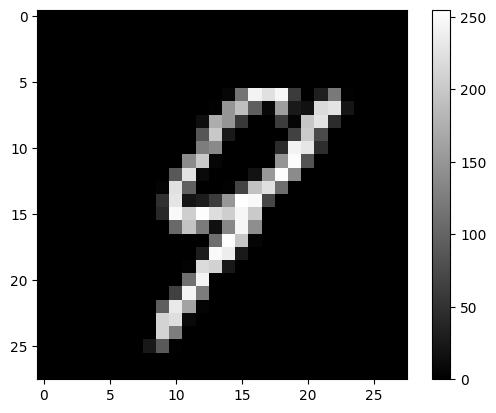

0.9971266
0.002865164168724732


In [33]:


# Get a sample
sample=X_test[-1,:,:]
sample=np.reshape(sample,(1,28,28))
ensemble_preds_samples = [model_x(sample).numpy()[0,1] for model_x in (deep_ensemble)]
print(np.array(ensemble_preds_samples).mean())
uncertainty = np.array(ensemble_preds_samples).mean() * (1 - np.array(ensemble_preds_samples).mean())
print(uncertainty)


for i in range(0,10):
  sample_ood=ood_test[i,:,:]
  plt.figure()
  plt.imshow(sample_ood, cmap='gray')
  plt.colorbar()
  plt.grid(False)
  plt.show()
  sample_ood=np.reshape(sample_ood,(1,28,28))
  ensemble_preds_samples_ood = [model_x(sample_ood).numpy()[0,1] for model_x in (deep_ensemble)]
  print(np.array(ensemble_preds_samples_ood).mean())
  uncertainty = np.array(ensemble_preds_samples_ood).mean() * (1 - np.array(ensemble_preds_samples_ood).mean())
  print(uncertainty)

In [88]:
import official.nlp.modeling.layers as nlp_layers
epochs=10
class simplenet(tf.keras.Model):
    """Defines a multi-layer residual network."""
    def __init__(self, num_classes=1, num_layers=1, num_hidden=32,
                 dropout_rate=0.1, **classifier_kwargs):
        super().__init__()
        # Define class meta data.
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.classifier_kwargs = classifier_kwargs

        # Define the layers.
        self.input_layer = tf.keras.layers.Input((None,None))
        self.normalize_layer = tf.keras.layers.Rescaling(1/255.)
        self.reshape_layer = tf.keras.layers.Reshape((28, 28, 1))
        self.conv1 = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')
        self.maxpool1 = tf.keras.layers.MaxPool2D(2)
        self.conv2 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')
        self.maxpool2 = tf.keras.layers.MaxPool2D(2)
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')
        self.maxpool3 = tf.keras.layers.MaxPool2D(2)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(num_hidden)
        self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]
        self.classifier = self.make_output_layer(num_classes)

    def call(self, inputs):
        # Project the 2D input data to high dimension.
        normalized = self.normalize_layer(inputs)
        reshape_layer=self.reshape_layer(normalized)
        conv1 = self.conv1(reshape_layer)
        maxpool1 = self.maxpool1(conv1)
        conv2 = self.conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)
        conv3 = self.conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)
        flattened = self.flatten(maxpool3)
        dense = self.dense(flattened)

        # Compute the ResNet hidden representations.
        for i in range(self.num_layers):
            resid = self.dense_layers[i](dense)
            resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
            dense += resid

        return self.classifier(dense)

    def make_dense_layer(self):
        """Use the Dense layer as the hidden layer."""
        return tf.keras.layers.Dense(self.num_hidden, activation="relu")

    def make_output_layer(self, num_classes):
        """Use the Dense layer as the output layer."""
        return tf.keras.layers.Dense(
            num_classes, **self.classifier_kwargs)



# resnet_model = simplenet()
# resnet_model.build((None, None))
# resnet_model.summary()
# loss = tf.keras.losses.CategoricalCrossentropy()
# metrics = tf.keras.metrics.CategoricalAccuracy(),
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

# train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

# resnet_model.compile(**train_config)
# resnet_model.fit(
#     X_train,
#     Y_train,
#     validation_split=0.3,
#     epochs=epochs)


In [89]:
# test_filter = np.where((Y_test == 0))
# X_test_0=X_test[test_filter]
# output = resnet_model(X_test_0)
# plt.plot(output)
# uncertainty = output * (1. - output)
# plt.plot(uncertainty, c='r')
# plt.title('Test Set')

In [91]:
class simplenetSNGP(simplenet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        2,
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and a covariance matrix from the GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits
# sngp_model = simplenetSNGP(**resnet_config)
# sngp_model.build((None, None))
# sngp_model.summary()




class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()
class DeepResNetSNGPWithCovReset(simplenetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)
sngp_model = simplenetSNGP(**resnet_config)
sngp_model.build((None,None, None,1))
sngp_model.summary()
resnet_config = dict(num_classes=2)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy(),
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)
sngp_model.compile(**train_config)
sngp_model.fit(
    X_train,
    Y_train,
    validation_split=0.3,
    epochs=100)

Model: "simplenet_sngp_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_30 (Rescaling)    multiple                  0         
                                                                 
 reshape_24 (Reshape)        multiple                  0         
                                                                 
 conv2d_78 (Conv2D)          multiple                  160       
                                                                 
 max_pooling2d_78 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          multiple                  4640      
                                                                 
 max_pooling2d_79 (MaxPoolin  multiple                 0         
 g2D)                                            

KeyboardInterrupt: ignored

In [101]:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)

  return tf.nn.softmax(logits_adjusted, axis=-1)




(980,)


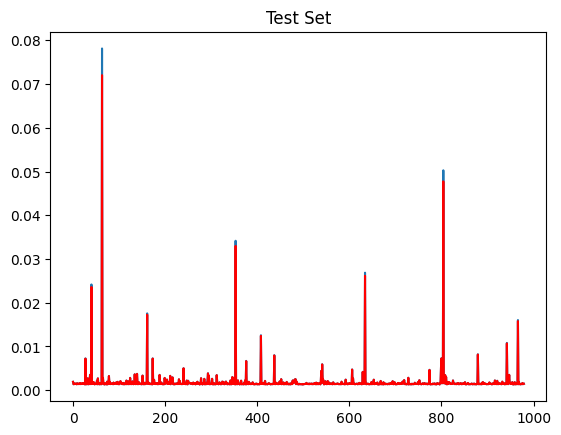

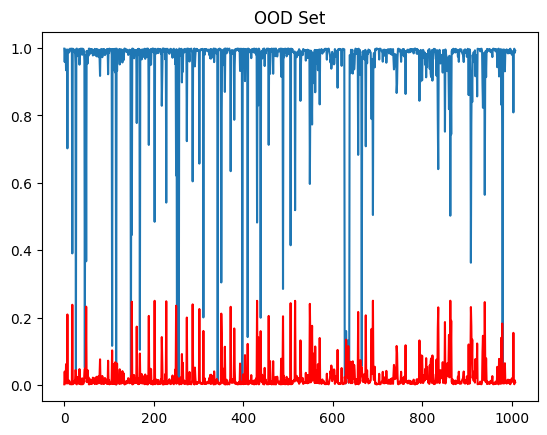

In [103]:
test_filter = np.where((Y_test == 0))
X_test_0=X_test[test_filter]
sngp_logits, sngp_covmat = sngp_model(X_test_0, return_covmat=True)

sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)
sngp_probs=sngp_probs[:,1]
print(np.shape(sngp_probs))
plt.plot(sngp_probs)
uncertainty = sngp_probs * (1. - sngp_probs)
plt.plot(uncertainty, c='r')
plt.title('Test Set')
plt.show()
sngp_logits_ood, sngp_covmat_ood = sngp_model(ood_test, return_covmat=True)
sngp_probs_ood = compute_posterior_mean_probability(sngp_logits_ood, sngp_covmat_ood)[:,1]
plt.plot(sngp_probs_ood)
uncertainty = sngp_probs_ood * (1. - sngp_probs_ood)
plt.plot(uncertainty, c='r')
plt.title('OOD Set')
plt.show()

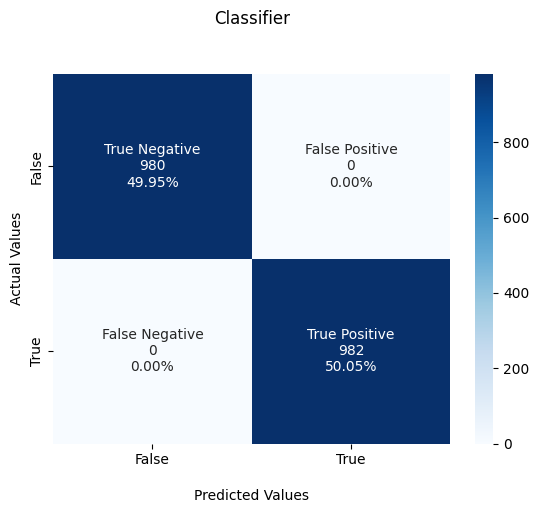

In [106]:
sngp_logits, sngp_covmat = sngp_model(X_test, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)


plot_confusion_matrix(Y_test,sngp_probs.numpy().argmax(axis=-1) )

## Bayesian Neural Network -Variational inference (VI) as an approximative Bayes approach

Now we will train a bayesian neural network via variational inference. We again use a CNN with two convolutional blocks, followed by maxpooling layers. The setting is the same as above.



The main idea of the Bayes approach in DL is that with BNNs, each weight is replaced
by a distribution. Normally, this is quite a complicated distribution, and this distribution
isn’t independent among different weights. The idea behind the VI Bayes
method is that the complicated posterior distributions of the weights are approximated
by a simple distribution called variational distribution.

In [ ]:
import tensorflow_probability as tfp
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.utils import to_categorical

disable_eager_execution()
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] *1.0)

model_vi = Sequential()
model_vi.add(layers.Rescaling(1./255, input_shape=(28, 28, 1)))
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(28,28,1)))
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tf.keras.layers.Flatten())
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(2, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))




X_train=X_train.reshape((-1,28,28,1))

model_vi.compile(tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['categorical_accuracy'])
epochs=50
print(np.shape(Y_train))

print(np.shape(Y_train))
model_vi.fit(
    X_train,
    Y_train_c,
    validation_split=0.3,
    epochs=epochs,
)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


(11765,)
(11765,)
Train on 8235 samples, validate on 3530 samples
Epoch 1/50
8235/8235 [==============================] - ETA: 0s - loss: 11.7930 - categorical_accuracy: 0.9197

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8235/8235 [==============================] - 5s 564us/sample - loss: 11.7930 - categorical_accuracy: 0.9197 - val_loss: 4.7826 - val_categorical_accuracy: 0.9929
Epoch 2/50
8235/8235 [==============================] - 3s 351us/sample - loss: 2.5624 - categorical_accuracy: 0.9871 - val_loss: 1.4780 - val_categorical_accuracy: 0.9938
Epoch 3/50
8235/8235 [==============================] - 3s 344us/sample - loss: 1.1734 - categorical_accuracy: 0.9949 - val_loss: 0.9386 - val_categorical_accuracy: 0.9915
Epoch 4/50
8235/8235 [==============================] - 4s 508us/sample - loss: 0.9633 - categorical_accuracy: 0.9745 - val_loss: 0.7924 - val_categorical_accuracy: 0.9830
Epoch 5/50
8235/8235 [==============================] - 5s 586us/sample - loss: 0.6748 - categorical_accuracy: 0.9905 - val_loss: 0.5679 - val_categorical_accuracy: 0.9946
Epoch 6/50
8235/8235 [==============================] - 3s 366us/sample - loss: 0.6927 - categorical_accuracy: 0.9866 - val_loss: 0.5837 - val_categor

In [ ]:
for i in range(0,5):
  print(model_vi.predict(X_test[0:1].reshape(1,28,28,1))[0])


for i in range(0,5):
  print(model_vi.predict(ood_test[0:1].reshape(1,28,28,1))[0])

# Whats Next?


1. Try the same experiment with different digits!
2. What about a medical dataset?
  - Create a copy of the notebook
  - Use the following code to load the data
  ```
    import os
    import matplotlib.pyplot as plt
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.models import Sequential
    import numpy as np
    import time
    import medmnist
    import random
    from sklearn.calibration import CalibratedClassifierCV
    from medmnist import INFO, Evaluator
    from medmnist.info import DEFAULT_ROOT
    from sklearn.metrics import *
    from sklearn import metrics as sklearn_metrics
    import seaborn as sns
    data_flag_class3 = "pathmnist"
    data_flag_class2 = "breastmnist"
    data_flag_class1 = "pneumoniamnist"

    output_root ="./ood"

    input_root = DEFAULT_ROOT

    def plot_confusion_matrix(y_true, y_pred):
        result = np.zeros(np.shape(y_pred)[0])
        result[y_pred[:,0] < 0.5] = 0
        result[y_pred[:,0] >= 0.5] = 1
        cf_matrix = sklearn_metrics.confusion_matrix(y_true, result)

        cfm_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
        cfm_values = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        cfm_percent = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cfm_labels, cfm_values, cfm_percent)]
        labels = np.asarray(labels).reshape(2, 2)

        ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
        ax.set_title('Classifier\n\n')
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values')

        # Ticket labels - List must be in alphabetical order
        ax.xaxis.set_ticklabels(['False', 'True'])
        ax.yaxis.set_ticklabels(['False', 'True'])

        # Display the visualization of the Confusion Matrix.
        plt.show()
    def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

    info = INFO[data_flag_class1]
    task = info['task']
    _ = getattr(medmnist, INFO[data_flag_class1]['python_class'])(
            split="train", root=input_root, download=True)

    output_root = os.path.join(output_root, data_flag_class1, time.strftime("%y%m%d_%H%M%S"))
    if not os.path.isdir(output_root):
        os.makedirs(output_root)

    info = INFO[data_flag_class2]
    task = info['task']
    _ = getattr(medmnist, INFO[data_flag_class2]['python_class'])(
            split="train", root=input_root, download=True)

    output_root = os.path.join(output_root, data_flag_class2, time.strftime("%y%m%d_%H%M%S"))

    info = INFO[data_flag_class3]
    task = info['task']
    _ = getattr(medmnist, INFO[data_flag_class3]['python_class'])(
            split="train", root=input_root, download=True)

    output_root = os.path.join(output_root, data_flag_class3, time.strftime("%y%m%d_%H%M%S"))
    if not os.path.isdir(output_root):
        os.makedirs(output_root)

    npz_file_class1 = np.load(os.path.join(input_root, "{}.npz".format(data_flag_class1)))
    npz_file_class2 = np.load(os.path.join(input_root, "{}.npz".format(data_flag_class2)))
    npz_file_class3 = np.load(os.path.join(input_root, "{}.npz".format(data_flag_class3)))
    ood_test = npz_file_class3['train_images'][:580,...]
    ood_test=ood_test[:,:,:,0:1]
    print(np.shape(ood_test))
    X_train = np.concatenate((npz_file_class1['train_images'][:580,...], npz_file_class2['train_images']), axis=0)
    Y_train =np.concatenate((np.zeros(np.shape(npz_file_class1['train_images'][:580,...])[0]), np.ones(np.shape(npz_file_class2['train_images'])[0])), axis=0)
    X_train,Y_train= unison_shuffled_copies(X_train, Y_train)
    X_test = np.concatenate((npz_file_class1['test_images'][:80,...], npz_file_class2['test_images']), axis=0)
    Y_test =np.concatenate((np.zeros(np.shape(npz_file_class1['test_images'][:80,...])[0]), np.ones(np.shape(npz_file_class2['test_images'])[0])), axis=0)
  ```
